## MIP data analysis.
---
This notebook assumes you have at least one MIPWrangler output file with accompanying sample list located in your **data_directory** and that data directory be bound to /opt/data in the container. i.e. *-B /path/to/your/data_dir/:/opt/data*  

You must have the base_resources directory from the github repository bound to /opt/resources in the container. i.e. *-B /path/to/your/base_resources:/opt/resources*  

You must have the project_resources directory provided separately bound to /opt/projet_resources.
___
You should run each of the code cells in order, using the toolbar above or ctrl+enter.  

If the cell starts with **# RUN**, run the cell with no change.  

If the cell starts with **# USER INPUT**, you **must** specify some parameter before running the cell.  

If the cell starts with **# OPTIONAL USER INPUT**, you may specify some parameter before running the cell. Otherwise the default values specified in the cell will be used.  

Reference command:
```bash
singularity run --app jupyter -B 
/home/oaydemir/git/MIPMaker/base_resources/:/opt/resources -B /home/
oaydemir/resources/species_resources/pf/Pf_3D7_v3-PDB9.3/:/opt/speci
es_resources -B /home/oaydemir/resources/project_resources/DR2/:/opt
/project_resources -B /home/oaydemir/processed/:/opt/data -B /home/o
aydemir/fast_data/analysis/DR2_180723/:/opt/analysis -B /home/oaydem
ir/git:/opt/extras /home/oaydemir/miptools/
```

In [1]:
# RUN
import sys
sys.path.append("/opt/src")
import mip_functions as mip
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

mip module reloading
functions reloading


### Specify MIPWrangler output file(s).  
When combining more than one sequencing run, the sample list for each run should be in the same order as the MIPWrangler output file. For example, 
```python
info_files = ["sequencing_run_1_wrangler_output.gz", "sequencing_run_2_wrangler_output.gz"]
sample_sheets = ["sample_sheet_for_sequencing_run_1.tsv", "sample_sheet_for_sequencing_run_2.tsv"]
```

In [2]:
# USER INPUT
info_files = ["180703_CTL_DR2.txt.gz", "180703_AG_DR2.txt.gz"]
sample_sheets = ["180703_samples.tsv", "180703_samples.tsv"]

In [3]:
# RUN
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]

### Preview the sample sheets you provided
Just to have an idea what was included in the sequencing run.

In [4]:
# RUN
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

sample_name  replicate   fw  rev      owner  \
sample_set probe_set                                                     
AG         DR2               01CCR5205          1    1  265  Benedicta   
           IBC               10GHR5001          1  193   37    patrick   
CTL        DR2                      HC          1  289  169  Benedicta   
           HRP2                  3D7-Q          3  301  181    patrick   
           HRP3                  3D7-Q          5  325  109    patrick   
           HRPF                  3D7-Q          7  349  133    patrick   
IBC        IBC                     190          1   98  350    patrick   
JJJ        IBC        1-6RTISPGE02-02S          1    2   38     Travis   

                                    Capture Plate Name Capture Plate Location  \
sample_set probe_set                                                            
AG         DR2                                       K                    A01   
           IBC        IBC_MDR_2014_Cape_Coast_Hospital                    A01   
CTL        DR2                                 Strip-1                      1   
           HRP2                     180702-HRP-testing                    A01   
           HRP3                     180702-HRP-testing                    C01   
           HRPF                     180702-HRP-testing                    E01   
IBC        IBC                       180424_IBC_Uganda                    A02   
JJJ        IBC                                Plate_25                    A02   

                      Library Prep  
sample_set probe_set                
AG         DR2              180703  
           IBC              180509  
CTL        DR2              180703  
           HRP2             180703  
           HRP3             180703  
           HRPF             180703  
IBC        IBC              180427  
JJJ        IBC              171027

### Specify sample groups to analyze
All samples summarized in the sample sheet (see above) are assumed to be part of this analylsis by default. However, it is not the case for some situations. Most of the time there will be multiple libraries included in a sequence run, and the sample sheet will include all of them. The MIPWrangler output files, on the other hand, are specific to a single sample set and probe set. So, the sample sheet may have samples listed that have no data provided here. Those samples will be treated as samples with no data and will be included in some analysis as samples without data. This is fine if we don't care about samples that did not work. However, we may want to know about the samples that **are** part of our experiment but do not have data; and want to separate them from samples that, by design, do not have any data in this analysis (because our data is specific to a single sample/probe set).  

There are two ways to achieve this.  
1  Change the sample sheet to include only our samples of interest, removing all others.
2  Specify in the below cell which sample groups we're interested in using the following syntax:  
assuming our sample sheet has these sample_set/probe_set groups:  

sample set: CTL probe_set: DR1,VAR4  
sample set: AG probe_set: DR2  
sample set: NTP probe_set: DR1,VAR4  

and we are analyzing data for CTL/DR1,VAR4 and NTP/DR1/VAR4:  
```python
sample_groups = [["CTL", "DR1,VAR4"],
                 ["NTP", "DR1,VAR4"]]
```

or if we want a single group:  
```python
sample_groups = [["CTL", "DR1,VAR4"]]
```

Note that there are still 2 brackets surrounding the text.  

if we change the sample sheet to include only the sample groups of interest or we do not care about the distinction between missing samples that should be present and missing samples that are supposed to be missing then we'd use:  
```python
sample_groups = None
```

Now any sample from the CTL or NTP sample sets without data will be treated as missing data.  
Whereas any sample in the AG group will not be considered at all during the analysis.  

Also of note here, while it is possible analyze multiple experiments using different probe sets all together, it is not recommended. For example, following the example here, if we included the AG/DR2 sample group, these samples will not have any data for the probes in DR1, or VAR4 and will have big chunks of missing data while the CTL and NTP groups will have the same problem for probes in the DR2 probe set.  

It *is* OK to use multiple groups if they share at least one probe set. Make sure to specify **only** that probe set when providing probe_sets_used below.

In [5]:
# OPTIONAL USER INPUT
sample_groups = [["CTL", "DR2"], ["AG", "DR2"]]

### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the sample sheet summary above under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma. For example,  
```python
species = "pf"
probe_sets_used = "DR1,VAR4"
```

In [6]:
# USER INPUT
species =  "pf"
probe_sets_used = "DR2"

In [7]:
# OPTIONAL USER INPUT
##############      SETTINGS FOR DATA FILTERS    ##################
###################################################################
###################################################################
# filters for a haplotype to be considered valid,
# across all samples in an analysis.
# minimum total barcodes
minHaplotypeBarcodes = 0
# minimum number of samples that the haplotype is observed in
minHaplotypeSamples = 0
# minimum fraction of samples that the haplotype is observed in
minHaplotypeSampleFraction = 0
###################################################################
###################################################################
# filters for a variant to be considered valid, across all samples 
# similar to haplotype filters
minVariantBarcodes = 5
minVariantSamples = 2
minVariantSampleFraction = 0
# Phred quality filter for individual variants. This is not used
# per variant overall, but within each sample for each variant.
minVariantQuality = 20
# Filters for aminoacid changes (referred to as mutations here)
# minimum (within sample) information of a variant to be considered
# for genotype calling. For example, if minMutationFraction is set 
# to 0.01 and a mutation is at 0.005 frequency in a sample, it'll be 
# called WT or REF; if frequency is between 0.01 and 0.99; 
# it'll be called MIX or HET; if over 0.99, it'll be called MUT or HOM
minMutationFraction = 0.005
# minimum barcode count for a mutation to be considered valid
minMutationCount = 2
# minimum coverage for a loci to make a genotype call
minCoverage = 5
# Merge nucleotide changes happening on the same codon to convert t
# Use only for Plasmodium
mergeSNPs = 1

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [8]:
# RUN
# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]
# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"mipSetKey" : mipSetKey, 
               "minHaplotypeBarcodes": minHaplotypeBarcodes, 
               "minHaplotypeSamples": minHaplotypeSamples,
               "minHaplotypeSampleFraction": minHaplotypeSampleFraction,
               "minVariantBarcodes": minVariantBarcodes,
               "minVariantSamples": minVariantSamples,
               "minVariantQuality": minVariantQuality,
               "minMutationFraction": minMutationFraction,
               "minMutationCount": minMutationCount,
               "minCoverage": minCoverage,
               "mergeSNPs": mergeSNPs,
               "minMutationFraction": minMutationFraction,
               "minMutationCount": minMutationCount,
               "minCoverage": minCoverage,
               "mergeSNPs": mergeSNPs}
# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/" + species + "_settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])
# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)
# create probe sets dictionary
mip.update_probe_sets("/opt/project_resources/mip_ids/mipsets.csv",
                     "/opt/project_resources/mip_ids/probe_sets.json")

### Specify if there is a target file.
Targets file is project specific. Its default location is project_resources/ directory. For a target file project_resources/targets.tsv use:
```Python
targets_file = "/opt/project_resources/targets.tsv" 
```
If targets file is not available, **targets_file = None** should be used.  
```Python
targets_file = None
```

In [9]:
# OPTIONAL USER INPUT
targets_file = "/opt/project_resources/targets.tsv" 

### Specify how we want to add the "targeted locus" information to experiment results.
You can use:  
1. **target_join=intersection**: Filter variants so that only those in the initial targets list will remain. Annotate the variants with the information from targets file.  
2. **target_join=data**: Keep all variants in the data and annotate.  
3. **target_join=targets**: Keep only the variants in the target list (even if the variant is not observed in the data). This is useful when we're interested in knowing when a variant is not observed, such as drug resistance mutations.  
4. **target_join=union**: Keep all variants, annotate, add variants from targets file even if not observed.

In [10]:
# OPTIONAL USER INPUT
target_join = "union"

### Process data, call variants.
Below cell does the rest of the processing. It generates variant files with coverage information, calls genotypes and creates an annotated vcf file using the parameters from the settings file. Some statistics are produced during the process which are saved into the output variable, in case the notebook tab in the browser needs to be closed (since this step can take some time). You can reconnect to your notebook and see the output using the code cell following the process cell.

In [11]:
%%capture output
mip.combine_info_files(wdir,
                       settings_file, 
                      info_files,
                      sample_sheets,
                      settings["mipsterFile"],
                      sample_sets=sample_groups)
mip.process_haplotypes(wdir + settings_file)
mip.process_results(wdir,
                    settings_file,
                    [wdir + "samples.tsv"],
                    targets_file=targets_file,
                    target_join=target_join
                   )

### View the process output

In [12]:
# RUN
output.show()

5 alignments may have problems, please check alignments.tmp
102 out of 102 samples has meta information and will be used for analysis.
There are 28588 mapped and 114 unmapped (off target) haplotypes.
There are 96720 data points in raw data, 96543 are mapped to genome and their targets.
Total number of reads and barcodes were 27414531 and 7749003. On target number of reads and barcodes were 27406177 and 7746020.
There were 193089 total and 27395 unique variants, 
166238 total and 7048 unique variants remain after filtering variants for minimum total barcodes of 5, minimum observed sample number of 2, and minimum observed sample fraction of 0.0.
104750 total and 5942 unique variants remained after quality filtering for phred scores >= 20.
There are 92 samples with sequence data
There are 102 total samples.
Per sample mutation frequencies have been calculated for mutants with at least 2 supporting barcodes and loci with at least 5 coverage. Loci with less coverage will have NA frequencies

### Preview the results
Plotting the probe coverage by samples is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode (or however many is specified below) for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7e68892320>)

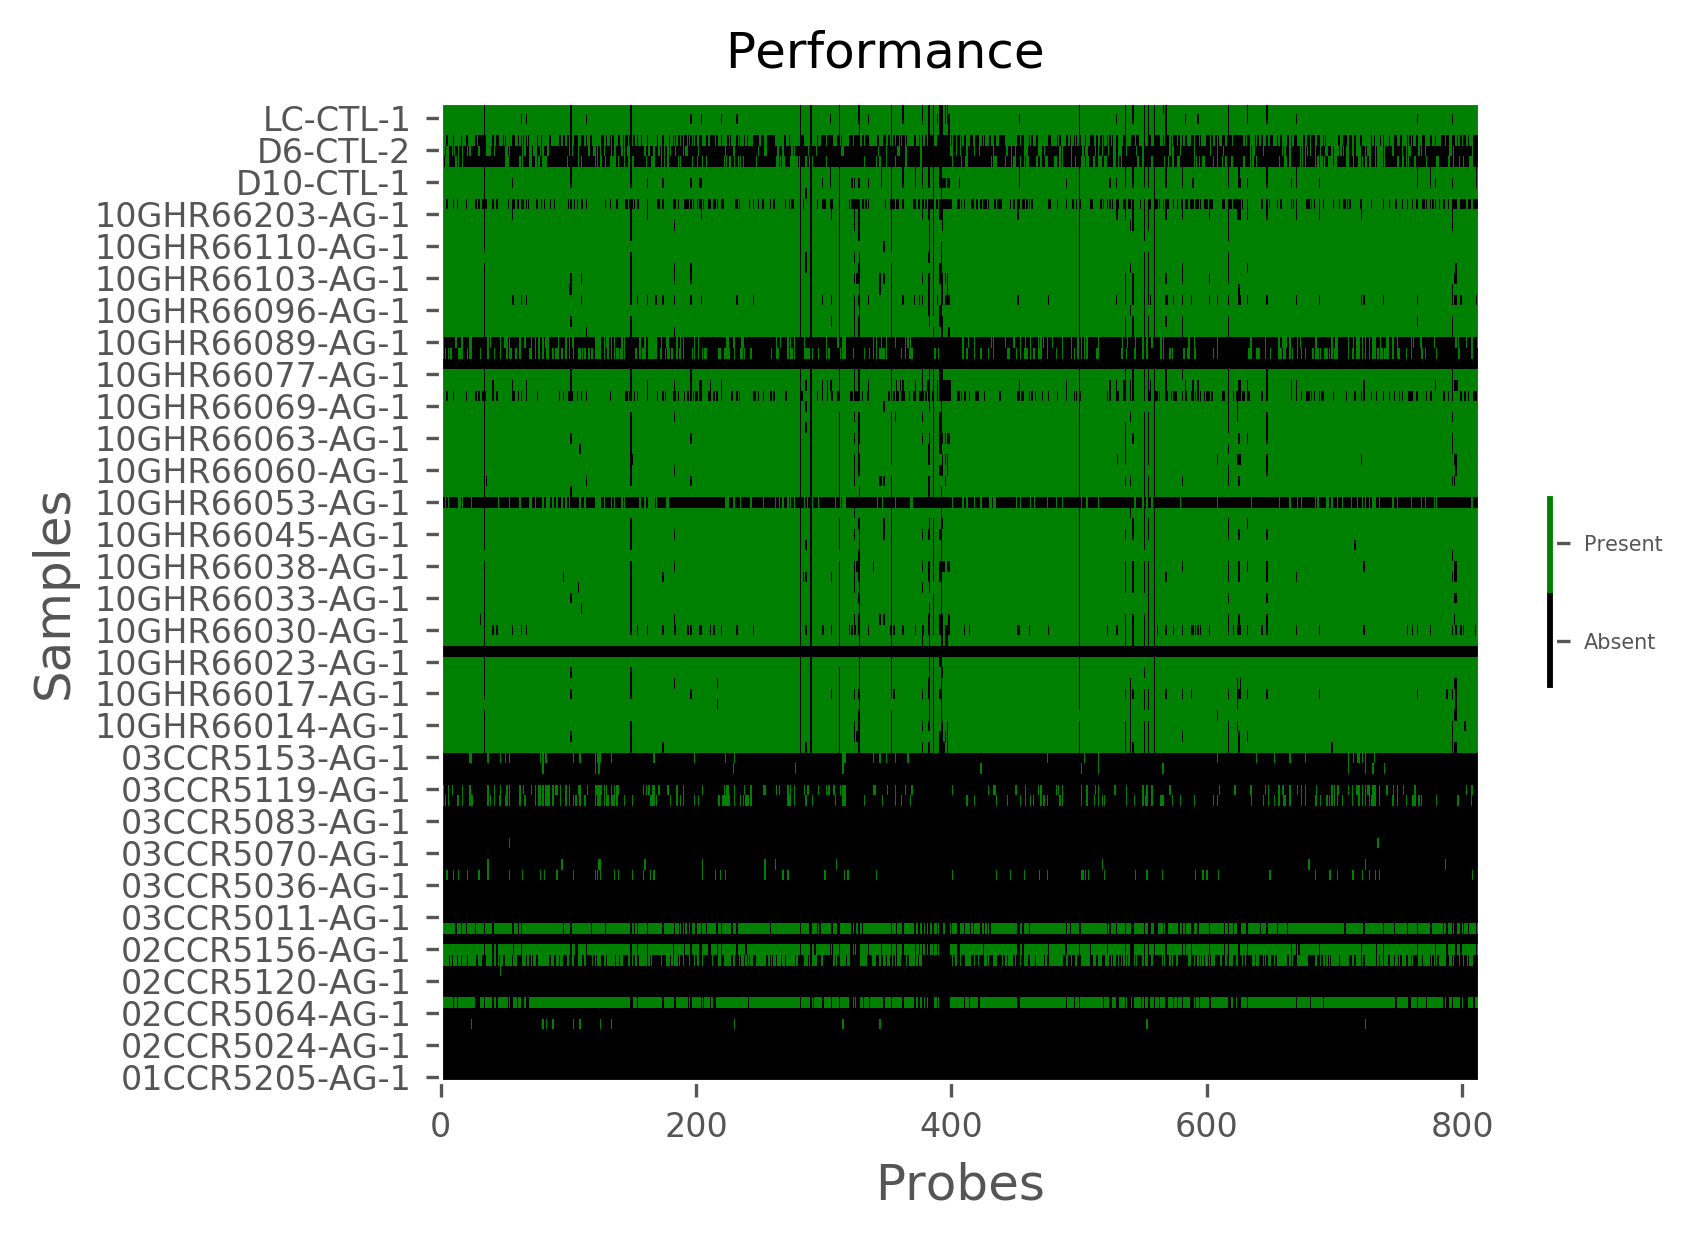

In [20]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=5, # anything below this number will be considered absent
                     tick_label_size=8, # font size for tick labels for x and y axis
                     cbar_label_size=5, # font size for heat map color bar
                     dpi=300, # figure resolution
                     absent_color='black',
                     present_color='green',
                     save=False, # If false, plots the graph here. If true, saves a .png in the analysis dir
                    ytick_freq=None, # How frequent the y-axis ticks should be (every nth column will have  a tick)
                    xtick_freq=None,
                    xtick_rotation=90) # x-axis tick label rotation 

### Look at summary stats 
There are summary statistics and meta data (if provided) we can use to determine if coverage is enough, whether further sequencing is necessary, and how to proceed if further sequencing will be needed.

In [21]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,01CCR5205-AG-1,1076.0,78.0,65,0,0
1,01CCR5207-AG-1,353.0,27.0,26,0,0
2,02CCR5021-AG-1,202.0,11.0,10,0,0
3,02CCR5024-AG-1,374.0,30.0,27,0,0
4,02CCR5026-AG-1,103.0,11.0,11,0,0


In [22]:
# RUN
meta = pd.read_csv(wdir + "merged_meta.csv")
meta.head()

,Unnamed: 0,Sample ID,Library Prep,sample_name,probe_set,fw,rev,owner,Capture Plate Name,Capture Plate Location,sample_set,Original SID,replicate,Sample Name,Meta
0,0,01CCR5205-AG-1,180703,01CCR5205,DR2,1,265,Benedicta,K,A01,AG,01CCR5205-AG-1,1,01CCR5205,Meta
1,1,01CCR5207-AG-1,180703,01CCR5207,DR2,2,266,Benedicta,K,A02,AG,01CCR5207-AG-1,1,01CCR5207,Meta
2,2,02CCR5021-AG-1,180703,02CCR5021,DR2,3,267,Benedicta,K,A03,AG,02CCR5021-AG-1,1,02CCR5021,Meta
3,3,02CCR5024-AG-1,180703,02CCR5024,DR2,4,268,Benedicta,K,A04,AG,02CCR5024-AG-1,1,02CCR5024,Meta
4,4,02CCR5026-AG-1,180703,02CCR5026,DR2,5,269,Benedicta,K,A05,AG,02CCR5026-AG-1,1,02CCR5026,Meta


A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

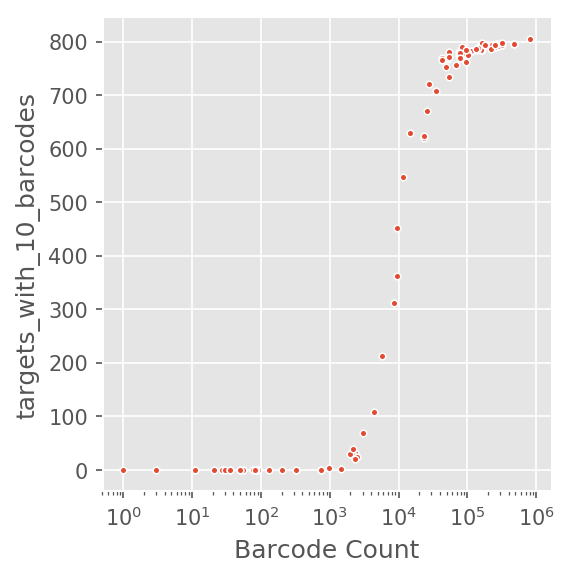

In [23]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **47 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 47
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

In [24]:
# USER INPUT
high_barcode_threshold = 100000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
barcode_coverage_threshold=10
barcode_count_threshold=100
low_coverage_action='Recapture'
assesment_key='targets_with_1_barcodes'
good_coverage_quantile=0.25

In [25]:
# RUN
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

Out of 92 samples 42 are completed, 32 will be recaptured and 18 repooled
3 samples showed uneven coverage, 0 complete, 2 to be recaptured, 1 repooled


### Inspect the repool document
Library to completion field in the repool document has the value (volume) of how much from a sample should be pooled for re-sequencing. These values are only rough estimates and care should be taken to make sure there will be enough material to sequence.

In [26]:
pd.read_csv(wdir + "repool.csv").head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes,Unnamed: 0,Library Prep,sample_name,probe_set,...,replicate,Sample Name,Meta,total_barcode_count,total_read_count,Status,Barcode Coverage,Library to Completion,Barcodes Per Target Covered,Uneven Coverage
0,01CCR5205-AG-1,1076.0,78.0,65,0,0,0,180703,01CCR5205,DR2,...,1,01CCR5205,Meta,78.0,1076.0,Recapture,13.794872,1281.051282,NaN,False
1,01CCR5207-AG-1,353.0,27.0,26,0,0,1,180703,01CCR5207,DR2,...,1,01CCR5207,Meta,27.0,353.0,Recapture,13.074074,3702.703704,NaN,False
2,02CCR5021-AG-1,202.0,11.0,10,0,0,2,180703,02CCR5021,DR2,...,1,02CCR5021,Meta,11.0,202.0,Recapture,18.363636,9089.909091,NaN,False
3,02CCR5024-AG-1,374.0,30.0,27,0,0,3,180703,02CCR5024,DR2,...,1,02CCR5024,Meta,30.0,374.0,Recapture,12.466667,3332.333333,NaN,False
4,02CCR5026-AG-1,103.0,11.0,11,0,0,4,180703,02CCR5026,DR2,...,1,02CCR5026,Meta,11.0,103.0,Recapture,9.363636,9089.909091,NaN,False


### Lets look at some files generated from the data
**variant_table.csv** file in your analysis directory contains all the variants passing filters specified in the settings file. The values in the table are each variant's ALT allele barcode depth in a given sample. Note that the value in paranthesis **range(12)** must match the number of header lines in the file. This depends on how many information fields from targets file are retained for final analysis. Experiment with values (9-12) to get the correct value that leaves only the numbers/values in the table and all other information on the column headers.

In [30]:
var_table = pd.read_csv(
    wdir + "variant_table.csv", 
    header = list(range(12)), index_col = 0
)
var_table.head()

CHROM                                   chr1                          \
POS                                 190260.0                190271.0   
ID                                         .                       .   
REF                                        G                       G   
ALT                                        A                    GTCT   
Gene                                  Pfubp1                  Pfubp1   
Mutation Name       Pfubp1-chr1:190260:.:G:A       Pfubp1-M1delinsMS   
AA Change Position                         .               M1delinsM   
ExonicFunc                                 . nonframeshift insertion   
Reference Resistant                       No                      No   
Targeted                                  No                      No   
Multi Mapping                             No                      No   
Sample ID                                                              
01CCR5205-AG-1                           0.0                     0.0   
01CCR5207-AG-1                           0.0                     0.0   
02CCR5021-AG-1                           0.0                     0.0   
02CCR5024-AG-1                           0.0                     0.0   
02CCR5026-AG-1                           0.0                     0.0   

CHROM                                                          \
POS                          190317.0                           
ID                                  .                           
REF                                 C                           
ALT                                 A                    CATA   
Gene                           Pfubp1                  Pfubp1   
Mutation Name             Pfubp1-H17N      Pfubp1-H17delinsHN   
AA Change Position                H17              H17delinsH   
ExonicFunc          nonsynonymous SNV nonframeshift insertion   
Reference Resistant                No                      No   
Targeted                           No                      No   
Multi Mapping                      No                      No   
Sample ID                                                       
01CCR5205-AG-1                    0.0                     0.0   
01CCR5207-AG-1                    0.0                     0.0   
02CCR5021-AG-1                    0.0                     0.0   
02CCR5024-AG-1                    0.0                     0.0   
02CCR5026-AG-1                    0.0                     0.0   

CHROM                                                                \
POS                                                                   
ID                                                                    
REF                                                                   
ALT                                 CATAATA              CATAATAATA   
Gene                                 Pfubp1                  Pfubp1   
Mutation Name           Pfubp1-H17delinsHNN    Pfubp1-H17delinsHNNN   
AA Change Position              H17delinsHN            H17delinsHNN   
ExonicFunc          nonframeshift insertion nonframeshift insertion   
Reference Resistant                      No                      No   
Targeted                                 No                      No   
Multi Mapping                            No                      No   
Sample ID                                                             
01CCR5205-AG-1                          0.0                     0.0   
01CCR5207-AG-1                          0.0                     0.0   
02CCR5021-AG-1                          0.0                     0.0   
02CCR5024-AG-1                          0.0                     0.0   
02CCR5026-AG-1                          0.0                     0.0   

CHROM                                                               \
POS                                                                  
ID                                                                   
REF                                        

**variant_coverage_table.csv** file has the same structure as the variant_table file. The values in this table has the _total coverage_ for the locus of each variant in each sample.

In [31]:
cov_table = pd.read_csv(
    wdir + "variant_coverage_table.csv", 
    header = list(range(12)), index_col = 0
)
cov_table.head()

CHROM                                   chr1                          \
POS                                 190260.0                190271.0   
ID                                         .                       .   
REF                                        G                       G   
ALT                                        A                    GTCT   
Gene                                  Pfubp1                  Pfubp1   
Mutation Name       Pfubp1-chr1:190260:.:G:A       Pfubp1-M1delinsMS   
AA Change Position                         .               M1delinsM   
ExonicFunc                                 . nonframeshift insertion   
Reference Resistant                       No                      No   
Targeted                                  No                      No   
Multi Mapping                             No                      No   
Sample ID                                                              
01CCR5205-AG-1                           0.0                     0.0   
01CCR5207-AG-1                           0.0                     0.0   
02CCR5021-AG-1                           0.0                     0.0   
02CCR5024-AG-1                           0.0                     0.0   
02CCR5026-AG-1                           0.0                     0.0   

CHROM                                                          \
POS                          190317.0                           
ID                                  .                           
REF                                 C                           
ALT                                 A                    CATA   
Gene                           Pfubp1                  Pfubp1   
Mutation Name             Pfubp1-H17N      Pfubp1-H17delinsHN   
AA Change Position                H17              H17delinsH   
ExonicFunc          nonsynonymous SNV nonframeshift insertion   
Reference Resistant                No                      No   
Targeted                           No                      No   
Multi Mapping                      No                      No   
Sample ID                                                       
01CCR5205-AG-1                    0.0                     0.0   
01CCR5207-AG-1                    0.0                     0.0   
02CCR5021-AG-1                    0.0                     0.0   
02CCR5024-AG-1                    0.0                     0.0   
02CCR5026-AG-1                    0.0                     0.0   

CHROM                                                                \
POS                                                                   
ID                                                                    
REF                                                                   
ALT                                 CATAATA              CATAATAATA   
Gene                                 Pfubp1                  Pfubp1   
Mutation Name           Pfubp1-H17delinsHNN    Pfubp1-H17delinsHNNN   
AA Change Position              H17delinsHN            H17delinsHNN   
ExonicFunc          nonframeshift insertion nonframeshift insertion   
Reference Resistant                      No                      No   
Targeted                                 No                      No   
Multi Mapping                            No                      No   
Sample ID                                                             
01CCR5205-AG-1                          0.0                     0.0   
01CCR5207-AG-1                          0.0                     0.0   
02CCR5021-AG-1                          0.0                     0.0   
02CCR5024-AG-1                          0.0                     0.0   
02CCR5026-AG-1                          0.0                     0.0   

CHROM                                                               \
POS                                                                  
ID                                                                   
REF                                        

We can easily get within sample allele frequency of each variant by dividing variant table by coverage table.  
Note: this table is already generated and in the analysis directory.

In [32]:
freq_table = var_table/cov_table
freq_table.head()

CHROM                                   chr1                          \
POS                                 190260.0                190271.0   
ID                                         .                       .   
REF                                        G                       G   
ALT                                        A                    GTCT   
Gene                                  Pfubp1                  Pfubp1   
Mutation Name       Pfubp1-chr1:190260:.:G:A       Pfubp1-M1delinsMS   
AA Change Position                         .               M1delinsM   
ExonicFunc                                 . nonframeshift insertion   
Reference Resistant                       No                      No   
Targeted                                  No                      No   
Multi Mapping                             No                      No   
Sample ID                                                              
01CCR5205-AG-1                           NaN                     NaN   
01CCR5207-AG-1                           NaN                     NaN   
02CCR5021-AG-1                           NaN                     NaN   
02CCR5024-AG-1                           NaN                     NaN   
02CCR5026-AG-1                           NaN                     NaN   

CHROM                                                          \
POS                          190317.0                           
ID                                  .                           
REF                                 C                           
ALT                                 A                    CATA   
Gene                           Pfubp1                  Pfubp1   
Mutation Name             Pfubp1-H17N      Pfubp1-H17delinsHN   
AA Change Position                H17              H17delinsH   
ExonicFunc          nonsynonymous SNV nonframeshift insertion   
Reference Resistant                No                      No   
Targeted                           No                      No   
Multi Mapping                      No                      No   
Sample ID                                                       
01CCR5205-AG-1                    NaN                     NaN   
01CCR5207-AG-1                    NaN                     NaN   
02CCR5021-AG-1                    NaN                     NaN   
02CCR5024-AG-1                    NaN                     NaN   
02CCR5026-AG-1                    NaN                     NaN   

CHROM                                                                \
POS                                                                   
ID                                                                    
REF                                                                   
ALT                                 CATAATA              CATAATAATA   
Gene                                 Pfubp1                  Pfubp1   
Mutation Name           Pfubp1-H17delinsHNN    Pfubp1-H17delinsHNNN   
AA Change Position              H17delinsHN            H17delinsHNN   
ExonicFunc          nonframeshift insertion nonframeshift insertion   
Reference Resistant                      No                      No   
Targeted                                 No                      No   
Multi Mapping                            No                      No   
Sample ID                                                             
01CCR5205-AG-1                          NaN                     NaN   
01CCR5207-AG-1                          NaN                     NaN   
02CCR5021-AG-1                          NaN                     NaN   
02CCR5024-AG-1                          NaN                     NaN   
02CCR5026-AG-1                          NaN                     NaN   

CHROM                                                               \
POS                                                                  
ID                                                                   
REF                                        

Genotypes can also be generated using these frequencies and some count filters.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an ALT (non-REF) base call is needed for a reliable call. If we set min_count = 2, any variant with an ALT call that has less than 2 barcodes supporting the ALT call will revert to REF.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the ALT allele within the sample, the locus would be called REF, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous ALT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutant_counts = mutant_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
coverage_counts = coverage_counts.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutant_counts / coverage_counts
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

### Amino acid changes
While variant specific files have information on base changes, there are also files that deal with amino acid changes only, referred to as mutations here as opposed to variants.  

The main difference between two types of data is that while two variants that are leading to the same amino acid change are considered separate variants, they would constitute the **same** mutation. A sample may have, for example, multiple distinct variants that correspond to the same *mutation* and all counts for those variants would be counted cumulatively for the single mutation call.  

Another important distinction between the variants and mutations is that the variants only deal with REF and ALT alleles. While mutations are classified as MUT or WT. While most of the time the ALT allele corresponds to the MUT call, it is sometimes possible that the REF allele encodes a mutation. The only example we have for this so far is the dhps-A437G allele which encodes a drug resistance mutation, Alanine being the WT allele and Glycine the drug resistant mutant. The 3d7 reference strain has the G allele. So when dealing with *variants* the A allele would be the ALT and G the REF, but they would be reversed to A:WT and G:MUT for mutation calls. This must be specified in the targets file by setting the "Reference Resistant" column value to "Yes".

Below we'll preview the count, coverage and genotype files for the *mutations*

In [35]:
mutation_counts = pd.read_csv(wdir + "mutant_table.csv",
                           index_col=0, header=list(range(4)))
mutation_counts.head()

Gene                       DHODH                              \
Mutation Name        DHODH-L351V DHODH-M1X       DHODH-N110Y   
Targeted                      No        No                No   
ExonicFunc     nonsynonymous SNV  stopgain nonsynonymous SNV   
Sample ID                                                      
01CCR5205-AG-1               0.0       0.0               0.0   
01CCR5207-AG-1               0.0       0.0               0.0   
02CCR5021-AG-1               0.0       0.0               0.0   
02CCR5024-AG-1               0.0       0.0               0.0   
02CCR5026-AG-1               0.0       0.0               0.0   

Gene                                                         PF3D7-0218600  \
Mutation Name         DHODH-S477fs       DHODH-V232I PF3D7-0218600-*2381fs   
Targeted                        No                No                    No   
ExonicFunc     frameshift deletion nonsynonymous SNV   frameshift deletion   
Sample ID                                                                    
01CCR5205-AG-1                 0.0               0.0                   0.0   
01CCR5207-AG-1                 0.0               0.0                   0.0   
02CCR5021-AG-1                 0.0               0.0                   0.0   
02CCR5024-AG-1                 0.0               0.0                   0.0   
02CCR5026-AG-1                 0.0               0.0                   0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1215_1216del PF3D7-0218600-1318_1319del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1464_1469del PF3D7-0218600-1464_1470del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                  ...                            pfv-atpase  \
Mutation Name         ...        pfv-atpase-chr13:1650781:.:A:T   
Targeted              ...                                    No   
ExonicFunc            ...                                     .   
Sample ID             ...                                         
01CCR5205-AG-1        ...                                   0.0   
01CCR5207-AG-1        ...                                   0.0   
02CCR5021-AG-1        ...                                   0.0   
02CCR5024-AG-1        ...                                   0.0   
02CCR5026-AG-1        ...                                   0.0   

Gene                                                                          \
Mutation Name  pfv-atpase-chr13:1650786:.:G:T pfv-atpase-chr13:1650789:.:A:T   
Targeted                                   No                             No   
ExonicFunc                                  .                              .   
Sample ID                                                                      
01CCR5205-AG-1                            0.0                    

In [36]:
mutation_coverage = pd.read_csv(wdir + "mutant_coverage.csv",
                           index_col=0, header=list(range(4)))
mutation_coverage.head()

Gene                       DHODH                              \
Mutation Name        DHODH-L351V DHODH-M1X       DHODH-N110Y   
Targeted                      No        No                No   
ExonicFunc     nonsynonymous SNV  stopgain nonsynonymous SNV   
Sample ID                                                      
01CCR5205-AG-1               0.0       0.0               0.0   
01CCR5207-AG-1               0.0       0.0               0.0   
02CCR5021-AG-1               0.0       1.0               0.0   
02CCR5024-AG-1               0.0       0.0               1.0   
02CCR5026-AG-1               0.0       0.0               0.0   

Gene                                                         PF3D7-0218600  \
Mutation Name         DHODH-S477fs       DHODH-V232I PF3D7-0218600-*2381fs   
Targeted                        No                No                    No   
ExonicFunc     frameshift deletion nonsynonymous SNV   frameshift deletion   
Sample ID                                                                    
01CCR5205-AG-1                 0.0               1.0                   0.0   
01CCR5207-AG-1                 0.0               0.0                   0.0   
02CCR5021-AG-1                 1.0               0.0                   0.0   
02CCR5024-AG-1                 0.0               0.0                   0.0   
02CCR5026-AG-1                 0.0               0.0                   0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1215_1216del PF3D7-0218600-1318_1319del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1464_1469del PF3D7-0218600-1464_1470del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        0.0                        0.0   
01CCR5207-AG-1                        0.0                        0.0   
02CCR5021-AG-1                        0.0                        0.0   
02CCR5024-AG-1                        0.0                        0.0   
02CCR5026-AG-1                        0.0                        0.0   

Gene                  ...                            pfv-atpase  \
Mutation Name         ...        pfv-atpase-chr13:1650781:.:A:T   
Targeted              ...                                    No   
ExonicFunc            ...                                     .   
Sample ID             ...                                         
01CCR5205-AG-1        ...                                   0.0   
01CCR5207-AG-1        ...                                   0.0   
02CCR5021-AG-1        ...                                   0.0   
02CCR5024-AG-1        ...                                   0.0   
02CCR5026-AG-1        ...                                   0.0   

Gene                                                                          \
Mutation Name  pfv-atpase-chr13:1650786:.:G:T pfv-atpase-chr13:1650789:.:A:T   
Targeted                                   No                             No   
ExonicFunc                                  .                              .   
Sample ID                                                                      
01CCR5205-AG-1                            0.0                    

Genotypes for mutations can also be generated in a similar way to the genotypes for variants.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an MUT (non-WT) aminoacid call is needed for a reliable call. If we set min_count = 2, any mutation with an MUT call that has less than 2 barcodes supporting the MUT call will revert to WT.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the MUT allele within the sample, the locus would be called WT, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous MUT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutant_counts = mutant_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
coverage_counts = coverage_counts.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutant_counts / coverage_counts
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

A genotypes.csv file is already generated using the cut off values provided in the settings file.

In [37]:
genotypes = pd.read_csv(wdir + "genotypes.csv",
                       header = list(range(4)),
                       index_col = 0)
genotypes.head()

Gene                       DHODH                              \
Mutation Name        DHODH-L351V DHODH-M1X       DHODH-N110Y   
Targeted                      No        No                No   
ExonicFunc     nonsynonymous SNV  stopgain nonsynonymous SNV   
Sample ID                                                      
01CCR5205-AG-1               NaN       NaN               NaN   
01CCR5207-AG-1               NaN       NaN               NaN   
02CCR5021-AG-1               NaN       NaN               NaN   
02CCR5024-AG-1               NaN       NaN               NaN   
02CCR5026-AG-1               NaN       NaN               NaN   

Gene                                                         PF3D7-0218600  \
Mutation Name         DHODH-S477fs       DHODH-V232I PF3D7-0218600-*2381fs   
Targeted                        No                No                    No   
ExonicFunc     frameshift deletion nonsynonymous SNV   frameshift deletion   
Sample ID                                                                    
01CCR5205-AG-1                 NaN               NaN                   NaN   
01CCR5207-AG-1                 NaN               NaN                   NaN   
02CCR5021-AG-1                 NaN               NaN                   NaN   
02CCR5024-AG-1                 NaN               NaN                   NaN   
02CCR5026-AG-1                 NaN               NaN                   NaN   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1215_1216del PF3D7-0218600-1318_1319del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        NaN                        NaN   
01CCR5207-AG-1                        NaN                        NaN   
02CCR5021-AG-1                        NaN                        NaN   
02CCR5024-AG-1                        NaN                        NaN   
02CCR5026-AG-1                        NaN                        NaN   

Gene                                                                  \
Mutation Name  PF3D7-0218600-1464_1469del PF3D7-0218600-1464_1470del   
Targeted                               No                         No   
ExonicFunc         nonframeshift deletion     nonframeshift deletion   
Sample ID                                                              
01CCR5205-AG-1                        NaN                        NaN   
01CCR5207-AG-1                        NaN                        NaN   
02CCR5021-AG-1                        NaN                        NaN   
02CCR5024-AG-1                        NaN                        NaN   
02CCR5026-AG-1                        NaN                        NaN   

Gene                  ...                            pfv-atpase  \
Mutation Name         ...        pfv-atpase-chr13:1650781:.:A:T   
Targeted              ...                                    No   
ExonicFunc            ...                                     .   
Sample ID             ...                                         
01CCR5205-AG-1        ...                                   NaN   
01CCR5207-AG-1        ...                                   NaN   
02CCR5021-AG-1        ...                                   NaN   
02CCR5024-AG-1        ...                                   NaN   
02CCR5026-AG-1        ...                                   NaN   

Gene                                                                          \
Mutation Name  pfv-atpase-chr13:1650786:.:G:T pfv-atpase-chr13:1650789:.:A:T   
Targeted                                   No                             No   
ExonicFunc                                  .                              .   
Sample ID                                                                      
01CCR5205-AG-1                            NaN                    

In [38]:
targeted_mutations = genotypes.xs("Yes", level="Targeted", axis=1)
targeted_mutations.head()

Gene                 PF3D7-1322700      PF3D7-1451200              atp6  \
Mutation Name  PF3D7-1322700-T236I PF3D7-1451200-N71N        atp6-A623E   
ExonicFunc       nonsynonymous SNV     synonymous SNV nonsynonymous SNV   
Sample ID                                                                 
01CCR5205-AG-1                 NaN                NaN               NaN   
01CCR5207-AG-1                 NaN                NaN               NaN   
02CCR5021-AG-1                 NaN                NaN               NaN   
02CCR5024-AG-1                 NaN                NaN               NaN   
02CCR5026-AG-1                 NaN                NaN               NaN   

Gene                                           crt                    \
Mutation Name         atp6-E431K         crt-A220S          crt-C72S   
ExonicFunc     nonsynonymous SNV nonsynonymous SNV nonsynonymous SNV   
Sample ID                                                              
01CCR5205-AG-1               NaN               NaN               NaN   
01CCR5207-AG-1               NaN               NaN               NaN   
02CCR5021-AG-1               NaN               NaN               NaN   
02CCR5024-AG-1               NaN               NaN               NaN   
02CCR5026-AG-1               NaN               NaN               NaN   

Gene                                                                  \
Mutation Name          crt-I356T          crt-K76T          crt-M74I   
ExonicFunc     nonsynonymous SNV nonsynonymous SNV nonsynonymous SNV   
Sample ID                                                              
01CCR5205-AG-1               NaN               NaN               NaN   
01CCR5207-AG-1               NaN               NaN               NaN   
02CCR5021-AG-1               NaN               NaN               NaN   
02CCR5024-AG-1               NaN               NaN               NaN   
02CCR5026-AG-1               NaN               NaN               NaN   

Gene                                    ...                     dhps  \
Mutation Name          crt-N326S        ...               dhps-S436A   
ExonicFunc     nonsynonymous SNV        ...        nonsynonymous SNV   
Sample ID                               ...                            
01CCR5205-AG-1               NaN        ...                      NaN   
01CCR5207-AG-1               NaN        ...                      NaN   
02CCR5021-AG-1               NaN        ...                      NaN   
02CCR5024-AG-1               NaN        ...                      NaN   
02CCR5026-AG-1               NaN        ...                      NaN   

Gene                                            fd              mdr1  \
Mutation Name         dhps-S436F          fd-D193Y       mdr1-D1246Y   
ExonicFunc     nonsynonymous SNV nonsynonymous SNV nonsynonymous SNV   
Sample ID                                                              
01CCR5205-AG-1               NaN               NaN               NaN   
01CCR5207-AG-1               NaN               NaN               NaN   
02CCR5021-AG-1               NaN               NaN               NaN   
02CCR5024-AG-1               NaN               NaN               NaN   
02CCR5026-AG-1               NaN               NaN               NaN   

Gene                                                                  \
Mutation Name        mdr1-N1042D         mdr1-N86Y       mdr1-S1034C   
ExonicFunc     nonsynonymous SNV nonsynonymous SNV nonsynonymous SNV   
Sample ID                                                              
01CCR5205-AG-1               NaN               NaN               NaN   
01CCR5207-AG-1               NaN               NaN               NaN   
02CCR5021-AG-1               NaN               NaN               NaN   
02CCR5024-AG-1               NaN               NaN               NaN   
02CCR5026-AG-1               NaN               NaN               NaN   

Gene                                          mdr2               pph  
Mutation

In [40]:
targeted_mutations.count()*100/targeted_mutations.shape[0]

Gene           Mutation Name        ExonicFunc       
PF3D7-1322700  PF3D7-1322700-T236I  nonsynonymous SNV    73.913043
PF3D7-1451200  PF3D7-1451200-N71N   synonymous SNV       66.304348
atp6           atp6-A623E           nonsynonymous SNV    71.739130
               atp6-E431K           nonsynonymous SNV    71.739130
crt            crt-A220S            nonsynonymous SNV    58.695652
               crt-C72S             nonsynonymous SNV    65.217391
               crt-I356T            nonsynonymous SNV    61.956522
               crt-K76T             nonsynonymous SNV    65.217391
               crt-M74I             nonsynonymous SNV    65.217391
               crt-N326S            nonsynonymous SNV    56.521739
dhfr-ts        dhfr-ts-C59R         nonsynonymous SNV    65.217391
               dhfr-ts-N51I         nonsynonymous SNV    65.217391
               dhfr-ts-S108N        nonsynonymous SNV    65.217391
dhps           dhps-A437G           nonsynonymous SNV    64.130435
        